In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import *
from sklearn.metrics import *
from sklearn.preprocessing import *

from sklearn.pipeline import Pipeline
from sklearn.svm import SVC, LinearSVC

from sklearn.model_selection import StratifiedKFold

from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

import xgboost as xgb

import matplotlib.pyplot as plt
import time

In [2]:
def TPR(y_true, y_pred):
    M = confusion_matrix(y_true, y_pred)
    TN, FP, FN, TP = M[0, 0], M[0, 1], M[1, 0], M[1, 1]
    return TP / (TP + FN)


def TNR(y_true, y_pred):
    M = confusion_matrix(y_true, y_pred)
    TN, FP, FN, TP = M[0, 0], M[0, 1], M[1, 0], M[1, 1]
    return TN / (TN + FP)

def intersection(lst1, lst2): 
    return list(set(lst1) & set(lst2)) 

In [3]:
# Load TCGA RNA-seq data
df = pd.read_csv("../../data/breast_cancer/BRCA_U133A.csv", index_col=0)
print(df.shape)

(474, 13397)


In [4]:
# Option #1: take 8-gene signature

# 1: хорошие гены от Степана
# genes = ["CDK1", "FOXM1", "LRIG2", "MSH2", "PLK1", "RACGAP1", "RRM2", "TMPO"]

# 2: OK - получены по значениям SHAP на основе ансамбля деревьев (не помню, какие были параметры)
#genes = ["EGOT", "KMT2A", "HSPD1", "PFKL", "EPCAM", "ELL3", "PRC1", "RACGAP1", "UBE2V1P9"]

# 3: OK -удалил ген PFKL из предыдущего списка
#genes = ["EGOT", "KMT2A", "HSPD1", "EPCAM", "ELL3", "PRC1", "RACGAP1", "UBE2V1P9"]

# 4:
genes = ["CASC1","MSLN","PTTG1","DLG3","TTK" ] #, "CKAP5", "RAB11FIP3", "PDHA1", "PRC1", "LMNB1", "DTL", "RPS29", "NMU"]

# Option #2: other 3 genes
#genes = ["BUB1B", "KIF4A", "PPFIA1"]

# Option #3: get good genes from file
#print("---- Loading good genes from file ---- ")
#good_genes = pd.read_csv("../../doc/src_from_Stepan/good_genes.txt")
#good_gene_names = good_genes['gene_name'].tolist()
#all_genes = list( df.columns[0:13394].values)
#genes = intersection(good_gene_names, all_genes)
#print("  found %s good genes that are present in dataset" % len(genes))
#all_genes = list( df.columns[0:13394].values )
#genes = all_genes

# Get subset: 
X_all = df.loc[df["Dataset"].isin(["GSE3494", "GSE6532", "GSE12093", "GSE17705", "GSE1456"]), genes].to_numpy()
y_all = df.loc[df["Dataset"].isin(["GSE3494", "GSE6532", "GSE12093", "GSE17705", "GSE1456"]), "Class"].to_numpy()

#X = df.loc[df["Dataset"].isin(["GSE3494", "GSE6532"]), genes].to_numpy()
#y = df.loc[df["Dataset"].isin(["GSE3494", "GSE6532"]), "Class"].to_numpy()
#X = df.loc[df["Dataset"].isin(["GSE3494", "GSE6532", "GSE12093", "GSE17705", "GSE1456"]), genes].to_numpy()
#y = df.loc[df["Dataset"].isin(["GSE3494", "GSE6532", "GSE12093", "GSE17705", "GSE1456"]), "Class"].to_numpy()

X, X_test, y, y_test = train_test_split(X_all, y_all, test_size=0.6, random_state=7)


In [5]:
# Do scaling 
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

In [9]:
# Cross-validation parameters
splitter = RepeatedStratifiedKFold(n_splits=5, n_repeats=100)

In [10]:
# Linear SVM classifier
classifier_1 = SVC(kernel="linear", class_weight="balanced", probability=True)
parameters_to_optimize_1 = {"C": np.logspace(-4, 4, 9, base=4)}

# Cross-validation & grid search
start_time = time.time()
CV_1 = GridSearchCV(
    classifier_1,
    parameters_to_optimize_1,
    scoring="balanced_accuracy",
    cv=splitter,
    refit=True)
gs_results_1 = CV_1.fit(X, y)
print("--- classifier 1 trained in: %s seconds ---" % (time.time() - start_time))
print("Best parameters set found on development set:")
print()
print(CV_1.best_params_)

--- classifier 1 trained in: 180.20355415344238 seconds ---
Best parameters set found on development set:

{'C': 0.25}


Dataset: GSE3494
   cl_1:
      ROC AUC: 0.7193362193362194
      Sensitivity: 0.6666666666666666
      Specificity: 0.7619047619047619
*****************
Dataset: GSE6532
   cl_1:
      ROC AUC: 0.817687074829932
      Sensitivity: 0.7
      Specificity: 0.7959183673469388
*****************
Dataset: GSE12093
   cl_1:
      ROC AUC: 0.7588383838383839
      Sensitivity: 0.75
      Specificity: 0.7575757575757576
*****************
Dataset: GSE17705
   cl_1:
      ROC AUC: 0.7560897435897437
      Sensitivity: 0.7307692307692307
      Specificity: 0.725
*****************
Dataset: GSE1456
   cl_1:
      ROC AUC: 0.7540509259259259
      Sensitivity: 0.7083333333333334
      Specificity: 0.7083333333333334
*****************


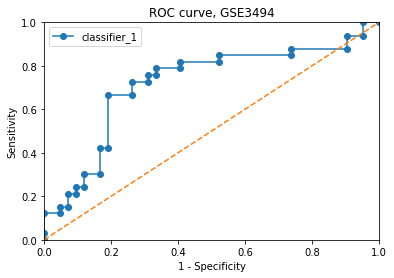

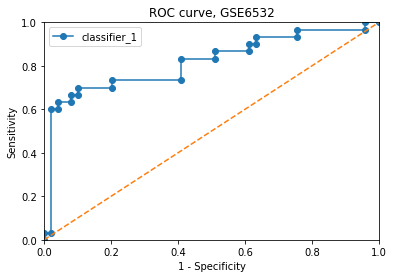

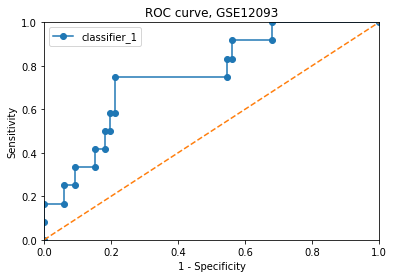

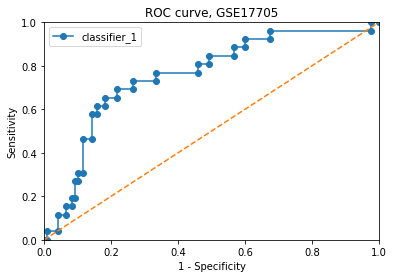

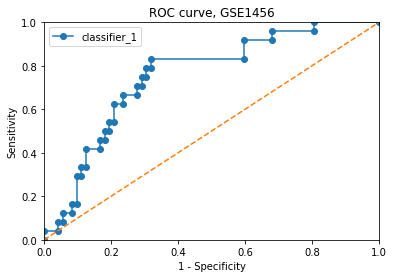

In [11]:
# Print results
for dataset in ["GSE3494", "GSE6532","GSE12093", "GSE17705", "GSE1456"]:
    X_test = df.loc[df["Dataset"] == dataset, genes].to_numpy()
    y_test = df.loc[df["Dataset"] == dataset, "Class"].to_numpy()
    X_test = scaler.transform(X_test)

    y_pred_1 = CV_1.predict(X_test)
    y_proba_1 = CV_1.predict_proba(X_test)
    fpr_1, tpr_1, thresholds_1 = roc_curve(y_test, y_proba_1[:, 1])
    roc_auc_1 = auc(fpr_1, tpr_1)

    #y_pred_2 = CV_2.predict(X_test)
    #y_proba_2 = CV_2.predict_proba(X_test)
    #fpr_2, tpr_2, thresholds_2 = roc_curve(y_test, y_proba_2[:, 1])
    #roc_auc_2 = auc(fpr_2, tpr_2)    
    
    print("Dataset: {}".format(dataset))
    print("   cl_1:")
    print("      ROC AUC: {}".format(roc_auc_1))
    print("      Sensitivity: {}".format(TPR(y_test, y_pred_1)))
    print("      Specificity: {}".format(TNR(y_test, y_pred_1)))
    #print("   cl_2:")
    #print("      ROC AUC: {}".format(roc_auc_2))
    #print("      Sensitivity: {}".format(TPR(y_test, y_pred_2)))
    #print("      Specificity: {}".format(TNR(y_test, y_pred_2)))
    print("*"*17)

    fig, ax = plt.subplots()
    plt.title('ROC curve, {}'.format(dataset))
    ax.plot(fpr_1, tpr_1, marker='o', label='classifier_1')
    #ax.plot(fpr_2, tpr_2, marker='o', label='classifier_2')        
    ax.plot([0, 1], [0, 1], '--')
    plt.xlim([0, 1]) 
    plt.ylim([0, 1])
    plt.ylabel('Sensitivity')
    plt.xlabel('1 - Specificity')
    ax.legend()
    plt.savefig("ROC_{}.pdf".format(dataset))
    #plt.close()
